                  Feature Name    Score    P-Value      Class Association
0                         CDPS 7.44e+02  8.64e-164  Postmenopause_Control
1                          LAP 3.28e+04   0.00e+00     Postmenopause_Case
2                         NRPS 3.34e+04   0.00e+00     Postmenopause_Case
3                    NRPS-like 3.23e+05   0.00e+00     Postmenopause_Case
4               RRE-containing 3.21e+02   7.15e-72     Postmenopause_Case
5                    RiPP-like 1.19e+04   0.00e+00     Postmenopause_Case
6                        T1PKS 2.91e+04   0.00e+00  Postmenopause_Control
7                        T3PKS 9.82e+03   0.00e+00     Postmenopause_Case
8                  arylpolyene 2.29e+03   0.00e+00  Postmenopause_Control
9                  betalactone 9.75e+02  3.92e-214  Postmenopause_Control
10  cyclic-lactone-autoinducer 3.01e+05   0.00e+00  Postmenopause_Control
11                      hybrid 1.92e+03   0.00e+00  Postmenopause_Control
12                   ladderane 1.93e+0

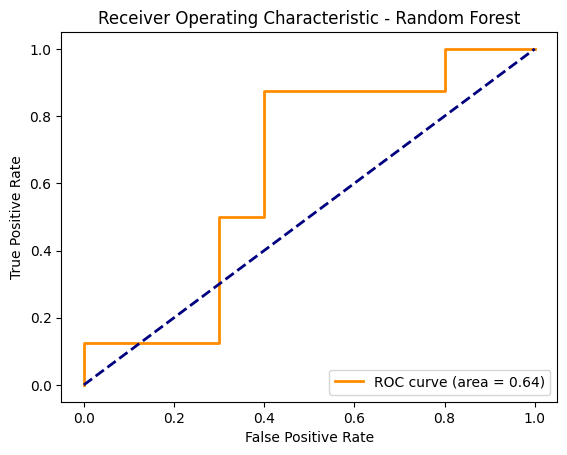

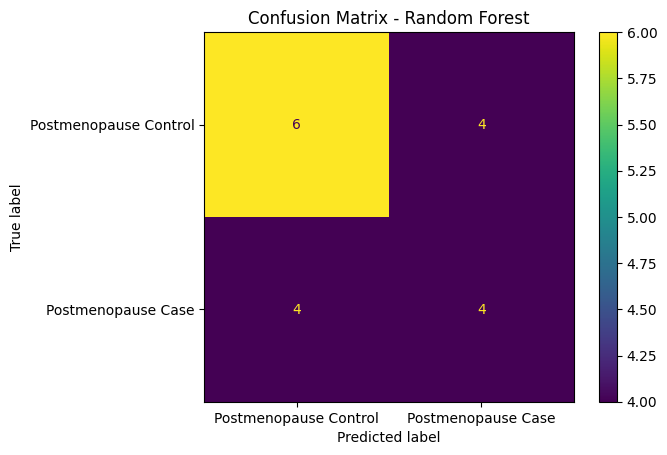

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.62      0.62      0.62         8

    accuracy                           0.67        18
   macro avg       0.66      0.66      0.66        18
weighted avg       0.67      0.67      0.67        18

Top 10 Features for XGBoost: ['siderophore', 'NRPS-like', 'cyclic-lactone-autoinducer', 'hybrid', 'NRPS', 'RiPP-like', 'lanthipeptide-class-ii', 'lanthipeptide-class-i', 'RRE-containing', 'terpene']
Cross-validation Accuracy for XGBoost: 0.64 (+/- 0.23)


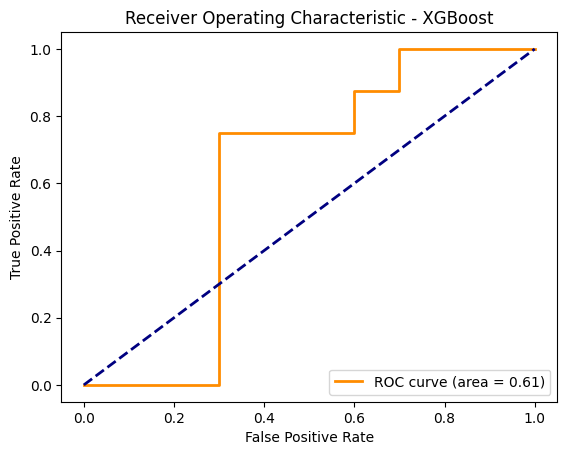

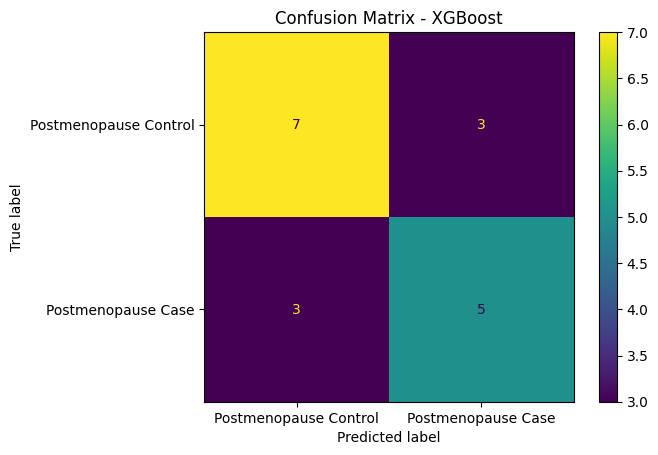

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.67      0.75      0.71         8

    accuracy                           0.72        18
   macro avg       0.72      0.72      0.72        18
weighted avg       0.73      0.72      0.72        18

Top 10 Features for Gradient Boosting: ['siderophore', 'hybrid', 'NRPS-like', 'RiPP-like', 'NRPS', 'ladderane', 'T1PKS', 'lanthipeptide-class-i', 'lanthipeptide-class-ii', 'cyclic-lactone-autoinducer']
Cross-validation Accuracy for Gradient Boosting: 0.68 (+/- 0.29)


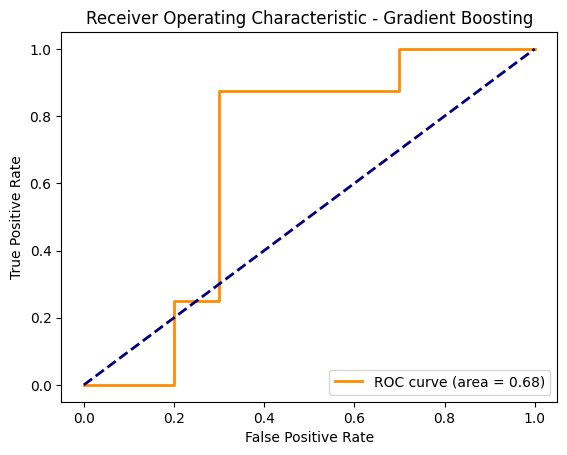

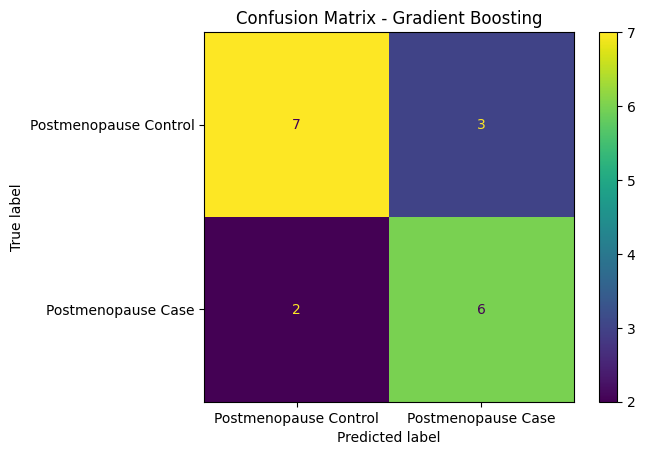

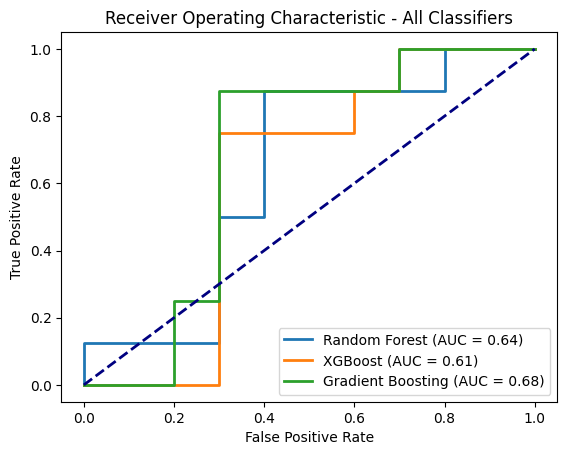

Stacking Ensemble Model Performance:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.62      0.62      0.62         8

    accuracy                           0.67        18
   macro avg       0.66      0.66      0.66        18
weighted avg       0.67      0.67      0.67        18



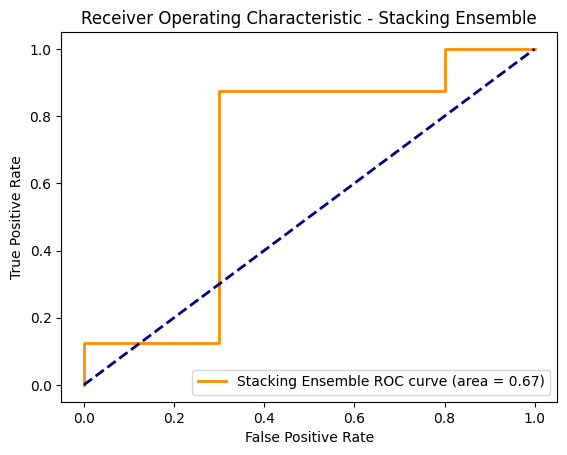

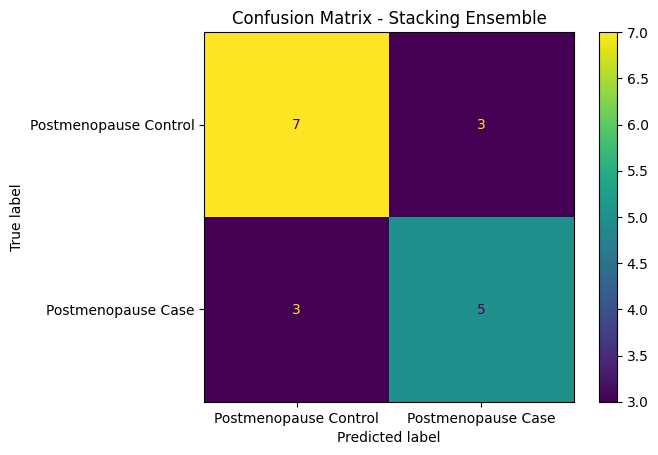

Top 10 Features for Stacking Ensemble: ['siderophore', 'NRPS', 'betalactone', 'hybrid', 'lanthipeptide-class-ii', 'RiPP-like', 'thiopeptide', 'NRPS-like', 'redox-cofactor', 'terpene']


In [6]:
import pandas as pd
import numpy as np
import os
import shutil
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import zipfile

def create_results_folder():
    folder_name = "Real_Postmen_BGC_Stacked"
    if os.path.exists(folder_name):
        shutil.rmtree(folder_name)
    os.makedirs(folder_name)
    return folder_name

def load_and_preprocess_data(bgc_path, metadata_path):
    bgc = pd.read_csv(bgc_path, index_col=0).T  # Assuming genes are rows, samples are columns
    metadata = pd.read_csv(metadata_path, index_col=0)  # Sample labels

    # Ensure bgc and metadata have the same samples
    common_samples = bgc.index.intersection(metadata.index)
    bgc = bgc.loc[common_samples]
    metadata = metadata.loc[common_samples]

    # Remove features with more than 90% zero values across samples
    bgc = bgc.loc[:, (bgc == 0).mean() <= 0.9]

    # Drop columns with NaN values
    bgc.dropna(axis=1, inplace=True)

    return bgc, metadata

def encode_labels(metadata, reference_group='Postmenopause_Control'):
    class_encoding = {reference_group: 0, 'Postmenopause_Case': 1}
    metadata['Data_group_encoded'] = metadata['Data_group'].map(class_encoding)
    return metadata

def feature_selection(bgc, metadata):
    chi2_values, p_values = chi2(bgc, metadata['Data_group_encoded'])
    class_means = bgc.groupby(metadata['Data_group_encoded']).mean()

    class_associations = []
    for feature in bgc.columns:
        if p_values[bgc.columns.get_loc(feature)] < 0.05:
            if class_means.loc[1, feature] > class_means.loc[0, feature]:
                class_associations.append('Postmenopause_Case')
            else:
                class_associations.append('Postmenopause_Control')
        else:
            class_associations.append('Not Significant')

    feature_info = pd.DataFrame({
        'Feature Name': bgc.columns,
        'Score': chi2_values,
        'P-Value': p_values,
        'Class Association': class_associations
    })

    feature_info['P-Value'] = feature_info['P-Value'].apply(lambda x: format(x, '.2e'))

    pd.set_option('display.float_format', lambda x: '%.2e' % x)
    print(feature_info)

    top_10_features = feature_info[feature_info['P-Value'].astype(float) < 0.05].nlargest(10, 'Score')

    return top_10_features, feature_info

def save_significant_features(folder, filename, feature_info):
    feature_info.to_csv(os.path.join(folder, filename), index=False)

def stratified_split(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def train_and_evaluate(X_train, y_train, X_test, y_test, classifiers, params, folder):
    roc_data = {}
    top_features = {}
    metrics_data = []
    model_predictions = {}

    for name, clf in classifiers.items():
        grid_search = GridSearchCV(clf, params[name], cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_clf = grid_search.best_estimator_
        predictions = best_clf.predict(X_test)
        model_predictions[name] = best_clf.predict_proba(X_test)[:, 1]

        print(f"{name} Performance:")
        report = classification_report(y_test, predictions, output_dict=True, zero_division=0)
        print(classification_report(y_test, predictions, zero_division=0))

        macro_precision = (report['0']['precision'] + report['1']['precision']) / 2
        macro_recall = (report['0']['recall'] + report['1']['recall']) / 2
        macro_f1 = (report['0']['f1-score'] + report['1']['f1-score']) / 2

        if hasattr(best_clf, 'feature_importances_'):
            feature_importance = best_clf.feature_importances_
            sorted_indices = np.argsort(feature_importance)[::-1]
            top_features[name] = [X_train.columns[i] for i in sorted_indices[:10]]
            print(f"Top 10 Features for {name}: {top_features[name]}")

        elif name == 'Logistic Regression' and hasattr(best_clf, 'coef_'):
            feature_importance = np.abs(best_clf.coef_[0])
            sorted_indices = np.argsort(feature_importance)[::-1]
            top_features[name] = [X_train.columns[i] for i in sorted_indices[:10]]
            print(f"Top 10 Features for {name}: {top_features[name]}")

        else:
            result = permutation_importance(best_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
            sorted_indices = np.argsort(result.importances_mean)[::-1]
            top_features[name] = [X_train.columns[i] for i in sorted_indices[:10]]
            print(f"Top 10 Features for {name}: {top_features[name]}")

        cv_results = cross_val_score(best_clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
        print(f"Cross-validation Accuracy for {name}: {cv_results.mean():.2f} (+/- {cv_results.std() * 2:.2f})")

        if hasattr(best_clf, "predict_proba"):
            y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = best_clf.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        roc_data[name] = (fpr, tpr, roc_auc)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - {name}')
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(folder, f'roc_curve_{name}.png'))
        plt.show()

        cm = confusion_matrix(y_test, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Postmenopause Control', 'Postmenopause Case'])
        disp.plot()
        plt.title(f'Confusion Matrix - {name}')
        plt.savefig(os.path.join(folder, f'confusion_matrix_{name}.png'))
        plt.show()

        metrics_data.append({
            'Model': name,
            'Accuracy': report['accuracy'],
            'Macro Precision': macro_precision,
            'Macro Recall': macro_recall,
            'Macro F1-Score': macro_f1,
            'AUC': roc_auc
        })

    return roc_data, top_features, metrics_data, model_predictions

def plot_combined_roc(roc_data, folder):
    plt.figure()
    for name, (fpr, tpr, roc_auc) in roc_data.items():
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - All Classifiers')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(folder, 'roc_curve_all_classifiers.png'))
    plt.show()

def save_top_features_per_model(top_features, folder, filename='top_10_significant_features_per_model.csv'):
    rows = []
    for model, features in top_features.items():
        for rank, feature in enumerate(features, start=1):
            rows.append({'Model': model, 'Rank': rank, 'Feature Name': feature})
    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(folder, filename), index=False)

def save_metrics(metrics_data, folder, filename='model_performance_metrics.csv'):
    df = pd.DataFrame(metrics_data)
    df.to_csv(os.path.join(folder, filename), index=False)

def create_and_zip_results_folder(folder):
    zip_filename = f"{folder}.zip"
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, _, files in os.walk(folder):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder))

# Main execution
bgc_path = "/content/postmen_bgc_abundance_matrix.csv"
metadata_path = "/content/metadata_postmen_control_case.csv"

results_folder = create_results_folder()

bgc, metadata = load_and_preprocess_data(bgc_path, metadata_path)
metadata = encode_labels(metadata)

top_10_significant_features, all_features = feature_selection(bgc, metadata)

save_significant_features(results_folder, "top_10_significant_features.csv", top_10_significant_features)
save_significant_features(results_folder, "all_features.csv", all_features)

X = bgc
y = metadata['Data_group_encoded']

X_train, X_test, y_train, y_test = stratified_split(X, y)

classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

params = {
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]},
    'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]}
}

roc_data, top_features, metrics_data, model_predictions = train_and_evaluate(X_train, y_train, X_test, y_test, classifiers, params, results_folder)
plot_combined_roc(roc_data, results_folder)

# Define base learners
base_learners = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

# Define the meta-classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(random_state=42),
    cv=StratifiedKFold(n_splits=5)
)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)
ensemble_pred = stacking_clf.predict(X_test)
ensemble_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]

# Evaluate the stacking ensemble
ensemble_report = classification_report(y_test, ensemble_pred, zero_division=0)
print("Stacking Ensemble Model Performance:")
print(ensemble_report)

# Calculate ROC for the ensemble
fpr, tpr, _ = roc_curve(y_test, ensemble_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Stacking Ensemble ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Stacking Ensemble')
plt.legend(loc="lower right")
plt.savefig(os.path.join(results_folder, 'roc_curve_stacking_ensemble.png'))
plt.show()

# Confusion Matrix for Stacking Ensemble
cm_ensemble = confusion_matrix(y_test, ensemble_pred)
disp_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['Postmenopause Control', 'Postmenopause Case'])
disp_ensemble.plot()
plt.title(f'Confusion Matrix - Stacking Ensemble')
plt.savefig(os.path.join(results_folder, 'confusion_matrix_stacking_ensemble.png'))
plt.show()

# Permutation Importance for the stacking model
result_ensemble = permutation_importance(stacking_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_indices_ensemble = np.argsort(result_ensemble.importances_mean)[::-1]
top_features['Stacking Ensemble'] = [X_train.columns[i] for i in sorted_indices_ensemble[:10]]
print(f"Top 10 Features for Stacking Ensemble: {top_features['Stacking Ensemble']}")

# Save ensemble performance metrics
ensemble_metrics = {
    'Model': 'Stacking Ensemble',
    'Accuracy': (ensemble_pred == y_test).mean(),
    'Macro Precision': (precision_score(y_test, ensemble_pred, average='macro')),
    'Macro Recall': (recall_score(y_test, ensemble_pred, average='macro')),
    'Macro F1-Score': (f1_score(y_test, ensemble_pred, average='macro')),
    'AUC': roc_auc
}
metrics_data.append(ensemble_metrics)
save_metrics(metrics_data, results_folder)

# Save the top features for each model to a CSV file
save_top_features_per_model(top_features, results_folder)

# Create and zip the results folder
create_and_zip_results_folder(results_folder)
